In [1]:
!pip install opendatasets

In [2]:
import opendatasets as od

od.download("https://www.kaggle.com/datasets/tezansahu/processed-daquar-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: syedosamaalishah092
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/tezansahu/processed-daquar-dataset


100%|██████████| 411M/411M [00:12<00:00, 34.3MB/s]


In [3]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [4]:
%%capture
# !pip install -U datasets
!pip install transformers==4.18.0 nltk==3.2.4 datasets==2.1.0 pandas==1.3.5

In [5]:
!git clone https://github.com/WongKinYiu/yolov9.git
%cd yolov9
!pip install -r requirements.txt -q

Cloning into 'yolov9'...
remote: Enumerating objects: 781, done.
remote: Counting objects: 100% (407/407), done.
remote: Compressing objects: 100% (167/167), done.
remote: Total 781 (delta 280), reused 277 (delta 228), pack-reused 374
Receiving objects: 100% (781/781), 3.30 MiB | 16.24 MiB/s, done.
Resolving deltas: 100% (325/325), done.
/content/yolov9
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 1.9 MB/s eta 0:00:00


In [9]:
import os
if os.path.exists("/content/yolov9"):
    if not os.path.exists("/content/yolov9/weights") or os.listdir("/content/yolov9/weights") is None:
        !wget -P {HOME}/yolov9/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-c.pt
        !wget -P {HOME}/yolov9/weights -q https://github.com/WongKinYiu/yolov9/releases/download/v0.1/yolov9-e.pt

    !ls -la {HOME}/yolov9/weights
else:
    print("Directory not found")

total 237676
drwxr-xr-x  2 root root      4096 Jul 23 18:52 .
drwxr-xr-x 13 root root      4096 Jul 23 18:52 ..
-rw-r--r--  1 root root 103153312 Feb 18 12:36 yolov9-c.pt
-rw-r--r--  1 root root 140217688 Feb 18 12:36 yolov9-e.pt


In [10]:
import argparse
import os
import platform
import sys
from pathlib import Path

import torch

from models.common import DetectMultiBackend
from utils.dataloaders import IMG_FORMATS, VID_FORMATS, LoadImages, LoadScreenshots, LoadStreams
from utils.general import (LOGGER, Profile, check_file, check_img_size, check_imshow, check_requirements, colorstr, cv2,
                           increment_path, non_max_suppression, print_args, scale_boxes, strip_optimizer, xyxy2xywh)
from utils.plots import Annotator, colors, save_one_box
from utils.torch_utils import select_device, smart_inference_mode

def yolov9(
    weights="/kaggle/working/yolov9/weights/yolov9-e.pt",  # model path or triton URL
    source="/kaggle/working/yolov9/data/images",  # file/dir/URL/glob/screen/0(webcam)
    data="/kaggle/working/yolov9/data/coco.yaml",  # dataset.yaml path
    imgsz=(640, 640),  # inference size (height, width)
    conf_thres=0.25,  # confidence threshold
    iou_thres=0.45,  # NMS IOU threshold
    max_det=1000,  # maximum detections per image
    device='',  # cuda device, i.e. 0 or 0,1,2,3 or cpu
    view_img=False,  # show results
    save_txt=False,  # save results to *.txt
    save_conf=False,  # save confidences in --save-txt labels
    save_crop=False,  # save cropped prediction boxes
    nosave=False,  # do not save images/videos
    classes=None,  # filter by class: --class 0, or --class 0 2 3
    agnostic_nms=False,  # class-agnostic NMS
    augment=False,  # augmented inference
    visualize=False,  # visualize features
    update=False,  # update all models
    project="runs/detect",  # save results to project/name
    name="exp",  # save results to project/name
    exist_ok=False,  # existing project/name ok, do not increment
    line_thickness=3,  # bounding box thickness (pixels)
    hide_labels=False,  # hide labels
    hide_conf=False,  # hide confidences
    half=False,  # use FP16 half-precision inference
    dnn=False,  # use OpenCV DNN for ONNX inference
    vid_stride=1,  # video frame-rate stride
    prediction=None # Detect only predicted object

):
    detected = []

    source = str(source)

    save_img = not nosave and not source.endswith('.txt')  # save inference images
    is_file = Path(source).suffix[1:] in (IMG_FORMATS + VID_FORMATS)
    is_url = source.lower().startswith(('rtsp://', 'rtmp://', 'http://', 'https://'))
    webcam = source.isnumeric() or source.endswith('.txt') or (is_url and not is_file)
    screenshot = source.lower().startswith('screen')
    if is_url and is_file:
        source = check_file(source)  # download

    # Directories
    save_dir = increment_path(Path(project) / name, exist_ok=exist_ok)  # increment run
    (save_dir / 'labels' if save_txt else save_dir).mkdir(parents=True, exist_ok=True)  # make dir

    # Load model
    device = select_device(device)
    model = DetectMultiBackend(weights, device=device, dnn=dnn, data=data, fp16=half)
    stride, names, pt = model.stride, model.names, model.pt
    imgsz = check_img_size(imgsz, s=stride)  # check image size

    # Dataloader
    bs = 1  # batch_size
    if webcam:
        view_img = check_imshow(warn=True)
        dataset = LoadStreams(source, img_size=imgsz, stride=stride, auto=pt, vid_stride=vid_stride)

        bs = len(dataset)
    elif screenshot:
        dataset = LoadScreenshots(source, img_size=imgsz, stride=stride, auto=pt)
    else:
        dataset = LoadImages(source, img_size=imgsz, stride=stride, auto=pt, vid_stride=vid_stride)
    vid_path, vid_writer = [None] * bs, [None] * bs

    # Run inference
    model.warmup(imgsz=(1 if pt or model.triton else bs, 3, *imgsz))  # warmup
    seen, windows, dt = 0, [], (Profile(), Profile(), Profile())
    for path, im, im0s, vid_cap, s in dataset:
        with dt[0]:
            im = torch.from_numpy(im).to(model.device)
            im = im.half() if model.fp16 else im.float()  # uint8 to fp16/32
            im /= 255  # 0 - 255 to 0.0 - 1.0
            if len(im.shape) == 3:
                im = im[None]  # expand for batch dim

        # Inference
        with dt[1]:
            visualize = increment_path(save_dir / Path(path).stem, mkdir=True) if visualize else False
            pred = model(im, augment=augment, visualize=visualize)
            pred = pred[0][1]


        # NMS
        with dt[2]:
            pred = non_max_suppression(pred, conf_thres, iou_thres, classes, agnostic_nms, max_det=max_det)

        # Second-stage classifier (optional)
        # pred = utils.general.apply_classifier(pred, classifier_model, im, im0s)

        # Process predictions
        for i, det in enumerate(pred):  # per image
            seen += 1
            if webcam:  # batch_size >= 1
                p, im0, frame = path[i], im0s[i].copy(), dataset.count
                s += f'{i}: '
            else:
                p, im0, frame = path, im0s.copy(), getattr(dataset, 'frame', 0)

            p = Path(p)  # to Path
            save_path = str(save_dir / p.name)  # im.jpg
            txt_path = str(save_dir / 'labels' / p.stem) + ('' if dataset.mode == 'image' else f'_{frame}')  # im.txt
#             s += '%gx%g ' % im.shape[2:]  # print string
            gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh
            imc = im0.copy() if save_crop else im0  # for save_crop
            annotator = Annotator(im0, line_width=line_thickness, example=str(names))
            if len(det):
                # Rescale boxes from img_size to im0 size
                det[:, :4] = scale_boxes(im.shape[2:], det[:, :4], im0.shape).round()

                # Print results
                for c in det[:, 5].unique():
                    n = (det[:, 5] == c).sum()  # detections per class

                    # get object name
#                     s += f"{n} {names[int(c)]}{'s' * (n > 1)} | "  # add to string
                    detected.append((int(n), names[int(c)])) # append a list with a tuple of detected object
                    # =====

                # Write results
                for *xyxy, conf, cls in reversed(det):
                    if save_txt:  # Write to file
                        xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh
                        line = (cls, *xywh, conf) if save_conf else (cls, *xywh)  # label format
                        with open(f'{txt_path}.txt', 'a') as f:
                            f.write(('%g ' * len(line)).rstrip() % line + '\n')

                    if save_img or save_crop or view_img:  # Add bbox to image
                        c = int(cls)  # integer class
                        label = None if hide_labels else (names[c] if hide_conf else f'{names[c]} {conf:.2f}')
                        annotator.box_label(xyxy, label, color=colors(c, True))
                    if save_crop:
                        save_one_box(xyxy, imc, file=save_dir / 'crops' / names[c] / f'{p.stem}.jpg', BGR=True)

            # Stream results
            im0 = annotator.result()
            if view_img:
                if platform.system() == 'Linux' and p not in windows:
                    windows.append(p)
                    cv2.namedWindow(str(p), cv2.WINDOW_NORMAL | cv2.WINDOW_KEEPRATIO)  # allow window resize (Linux)
                    cv2.resizeWindow(str(p), im0.shape[1], im0.shape[0])
                cv2.imshow(str(p), im0)
                cv2.waitKey(1)  # 1 millisecond

            # Save results (image with detections)
            if save_img:
                if dataset.mode == 'image':
                    cv2.imwrite(save_path, im0)
                else:  # 'video' or 'stream'
                    if vid_path[i] != save_path:  # new video
                        vid_path[i] = save_path
                        if isinstance(vid_writer[i], cv2.VideoWriter):
                            vid_writer[i].release()  # release previous video writer
                        if vid_cap:  # video
                            fps = vid_cap.get(cv2.CAP_PROP_FPS)
                            w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                            h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        else:  # stream
                            fps, w, h = 30, im0.shape[1], im0.shape[0]
                        save_path = str(Path(save_path).with_suffix('.mp4'))  # force *.mp4 suffix on results videos
                        vid_writer[i] = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                    vid_writer[i].write(im0)

        # Print time (inference-only)
#         LOGGER.info(f"{s}{'' if len(det) else '(no detections), '}{dt[1].dt * 1E3:.1f}ms")

    # Print results
    t = tuple(x.t / seen * 1E3 for x in dt)  # speeds per image
#     LOGGER.info(f'Speed: %.1fms pre-process, %.1fms inference, %.1fms NMS per image at shape {(1, 3, *imgsz)}' % t)
    if save_txt or save_img:
        s = f"\n{len(list(save_dir.glob('labels/*.txt')))} labels saved to {save_dir / 'labels'}" if save_txt else ''
#         LOGGER.info(f"Results saved to {colorstr('bold', save_dir)}{s}")
    if update:
        strip_optimizer(weights[0])  # update model (to fix SourceChangeWarning)

    return detected

In [12]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

from copy import deepcopy
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple
from datasets import load_dataset, set_caching_enabled
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
from transformers import (
    # Preprocessing / Common
    AutoTokenizer, AutoFeatureExtractor,
    # Text & Image Models (Now, image transformers like ViTModel, DeiTModel, BEiT can also be loaded using AutoModel)
    AutoModel, AutoConfig,
    # Training / Evaluation
    TrainingArguments, Trainer,
    # Misc
    logging
)
import warnings
warnings.filterwarnings('ignore')

import nltk
nltk.download('wordnet')

import nltk
import subprocess

# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/content/working/')
    command = "unzip /content/working/corpora/wordnet.zip -d /content/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/content/working/')

from nltk.corpus import wordnet

from sklearn.metrics import accuracy_score, f1_score


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet to /content/working/...


In [13]:
# cache for Hugging Face Transformers and Datasets.
os.environ['HF_HOME'] = os.path.join(".", "cache")

set_caching_enabled(True)
logging.set_verbosity_error()

In [14]:
#check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

cuda
NVIDIA A100-SXM4-40GB


In [15]:
# load dataset from CSV files for training and testing
dataset = load_dataset(
    "csv",
    data_files={
        "train": "/content/processed-daquar-dataset/data_train.csv",
        "test": "/content/processed-daquar-dataset/data_eval.csv"
    }
)

# read answer space from file and split into an array by line
with open("/content/processed-daquar-dataset/answer_space.txt") as f:
    answer_space = f.read().splitlines()

# label each item in the dataset with their respective answers
dataset = dataset.map(
    lambda examples: {
        'label': [
            answer_space.index(ans.replace(" ", "").split(",")[0])  # select the 1st answer if multiple answers are provided
            for ans in examples['answer']
        ]
    },
    batched=True
)

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-00a77bfc76d549bc/0.0.0/433e0ccc46f9880962cc2b12065189766fbb2bee57a221866138fb9203c83519. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

YOLO 🚀 v0.1-104-g5b1ea9a Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)

Fusing layers... 
Model summary: 839 layers, 68669632 parameters, 0 gradients, 241.4 GFLOPs


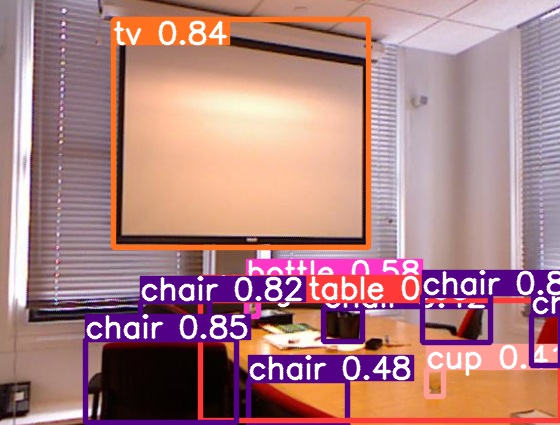

Question:	 how many red chairs are there
Answer:		 5 (Label: 15)
Objects:	 [(1, 'bottle'), (1, 'cup'), (6, 'chair'), (1, 'dining table'), (1, 'tv')]
Detected:	 False


'5'

In [16]:
import IPython.display as display

def show_example(train=True, idx=None, prediction=None):
    dataset_type = "train" if train else "test"
    data = dataset[dataset_type]

    if idx is None:
        idx = np.random.randint(len(data))

    # YOLOv9 detect ===
    objects = yolov9(
        source = "/content/processed-daquar-dataset/images/" + data[idx]['image_id'] + ".png",
        imgsz = (640, 640),
        conf_thres = 0.3,
        device = '',
        weights = "/content/yolov9/weights/yolov9-e.pt",
        name = data[idx]['image_id']
    )
    # =====

    image_path =  "/content/yolov9/runs/detect/" + f"{data[idx]['image_id']}/{data[idx]['image_id']}.png"
    image = Image.open(image_path)
    display.display(image)


    question = data[idx]["question"]
    answer = data[idx]["answer"]
    label = data[idx]["label"]

    # delete file from detect
    !rm -rf {HOME}/yolov9/runs/detect/ + f"{data[idx]['image_id']}"

    print(f"Question:\t {question}")
    print(f"Answer:\t\t {answer} (Label: {label})")
    print(f"Objects:\t {objects}")

    detect = False
    for obj in objects:
        if obj[1] in (prediction if prediction != None else answer):
            detect = True
            break

    print(f"Detected:\t {detect}")

    return answer
show_example()


In [32]:
@dataclass
class MultimodalCollator:
    tokenizer: AutoTokenizer
    preprocessor: AutoFeatureExtractor

    def tokenize_text(self, texts: List[str]) -> Dict[str, torch.Tensor]:
        """
        Tokenize text inputs and return relevant tokenized information.
        """
        encoded_text = self.tokenizer(
            text=texts,
            padding='longest',
            max_length=24,
            truncation=True,
            return_tensors='pt',
            return_token_type_ids=True,
            return_attention_mask=True,
        )
        return {
            "input_ids": encoded_text['input_ids'].squeeze(),
            "token_type_ids": encoded_text['token_type_ids'].squeeze(),
            "attention_mask": encoded_text['attention_mask'].squeeze(),
        }

    def preprocess_images(self, images: List[str]) -> Dict[str, torch.Tensor]:
        """
        Extract features from images and return the processed pixel values.
        """
        processed_images = self.preprocessor(
            images=[
                Image.open(os.path.join("/content/processed-daquar-dataset/images/", f"{image_id}.png")).convert('RGB')
                for image_id in images
            ],
            return_tensors="pt",
        )
        return {
            "pixel_values": processed_images['pixel_values'].squeeze(),
        }

    def __call__(self, raw_batch_dict) -> Dict[str, torch.Tensor]:
        """
        Process raw batch data, tokenize text and extract image features, returning a dictionary
        containing processed inputs and labels.
        """
        question_batch = raw_batch_dict['question'] if isinstance(raw_batch_dict, dict) else [i['question'] for i in raw_batch_dict]
        image_id_batch = raw_batch_dict['image_id'] if isinstance(raw_batch_dict, dict) else [i['image_id'] for i in raw_batch_dict]
        label_batch = raw_batch_dict['label'] if isinstance(raw_batch_dict, dict) else [i['label'] for i in raw_batch_dict]

        return {
            **self.tokenize_text(question_batch),
            **self.preprocess_images(image_id_batch),
            'labels': torch.tensor(label_batch, dtype=torch.int64),
        }



In [19]:
class MultimodalVQAModel(nn.Module):
    def __init__(
        self,
        num_labels: int = len(answer_space),
        intermediate_dim: int = 512,
        pretrained_text_name: str = 'roberta-base',
        pretrained_image_name: str = 'google/vit-base-patch16-224-in21k'
    ):
        """
        Initializes the Multimodal VQA Model.

        Args:
            num_labels (int): Number of labels in the answer space.
            intermediate_dim (int): Dimensionality of the intermediate layer in the fusion module.
            pretrained_text_name (str): Pretrained name for the text encoder.
            pretrained_image_name (str): Pretrained name for the image encoder.
        """
        super(MultimodalVQAModel, self).__init__()
        self.num_labels = num_labels
        self.pretrained_text_name = pretrained_text_name
        self.pretrained_image_name = pretrained_image_name

        # Text and image encoders

        self.text_encoder = AutoModel.from_pretrained(self.pretrained_text_name)
        self.image_encoder = AutoModel.from_pretrained(self.pretrained_image_name)

        # Fusion module
        self.fusion = nn.Sequential(
            nn.Linear(self.text_encoder.config.hidden_size + self.image_encoder.config.hidden_size, intermediate_dim),
            nn.ReLU(),
            nn.Dropout(0.5),
        )

        # Classifier
        self.classifier = nn.Linear(intermediate_dim, self.num_labels)

        # Loss function
        self.criterion = nn.CrossEntropyLoss()

    def forward(
        self,
        input_ids: torch.LongTensor,
        pixel_values: torch.FloatTensor,
        attention_mask: Optional[torch.LongTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        labels: Optional[torch.LongTensor] = None
    ):
        """
        Forward pass of the model.

        Args:
            input_ids (torch.LongTensor): Tokenized input IDs for text.
            pixel_values (torch.FloatTensor): Pixel values for images.
            attention_mask (Optional[torch.LongTensor]): Attention mask for text.
            token_type_ids (Optional[torch.LongTensor]): Token type IDs for text.
            labels (Optional[torch.LongTensor]): Ground truth labels.

        Returns:
            Dict: Dictionary containing model outputs, including logits. If labels are provided, also includes loss.
        """
        # Encode text with masking
        encoded_text = self.text_encoder(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            return_dict=True,
        )

        # Encode images
        encoded_image = self.image_encoder(
            pixel_values=pixel_values,
            return_dict=True,
        )

        # Combine encoded texts and images
        fused_output = self.fusion(
            torch.cat(
                [
                    encoded_text['pooler_output'],
                    encoded_image['pooler_output'],
                ],
                dim=1
            )
        )

        # Make predictions
        logits = self.classifier(fused_output)

        out = {"logits": logits}
        if labels is not None:
            loss = self.criterion(logits, labels)
            out["loss"] = loss

        return out

In [20]:
def create_multimodal_vqa_collator_and_model(text_encoder='roberta-base', image_encoder='google/vit-base-patch16-224-in21k'):
    """
    Creates a Multimodal VQA collator and model.

    Args:
        text_encoder (str): Pretrained name for the text encoder.
        image_encoder (str): Pretrained name for the image encoder.

    Returns:
        Tuple: Multimodal collator and VQA model.
    """
    # Initialize tokenizer and feature extractor
    tokenizer = AutoTokenizer.from_pretrained(text_encoder)
    preprocessor = AutoFeatureExtractor.from_pretrained(image_encoder)

    # Create Multimodal Collator
    multimodal_collator = MultimodalCollator(
        tokenizer=tokenizer,
        preprocessor=preprocessor,
    )

    # Create Multimodal VQA Model
    multimodal_model = MultimodalVQAModel(
        pretrained_text_name=text_encoder,
        pretrained_image_name=image_encoder
    ).to(device)

    return multimodal_collator, multimodal_model


In [21]:
def wup_measure(a, b, similarity_threshold=0.925):
    """
    Computes the Wu-Palmer similarity score between two words or phrases.

    Args:
        a (str): First word or phrase.
        b (str): Second word or phrase.
        similarity_threshold (float): Threshold for similarity to consider semantic fields.

    Returns:
        float: Wu-Palmer similarity score.
    """
    def get_semantic_field(word):
        """
        Retrieves the semantic field for a word.

        Args:
            word (str): Word to retrieve the semantic field for.

        Returns:
            Tuple: Tuple containing the semantic field and weight.
        """
        weight = 1.0
        semantic_field = wordnet.synsets(word, pos=wordnet.NOUN)
        return semantic_field, weight


    def get_stem_word(word):
        """
        Processes words in the form 'word\d+:wordid' by returning the word and downweighting.

        Args:
            word (str): Word to process.

        Returns:
            Tuple: Tuple containing the processed word and weight.
        """
        weight = 1.0
        return word, weight

    global_weight = 1.0

    # Get stem words and weights
    a, global_weight_a = get_stem_word(a)
    b, global_weight_b = get_stem_word(b)
    global_weight = min(global_weight_a, global_weight_b)

    # Check if words are the same
    if a == b:
        return 1.0 * global_weight

    # Check for empty strings

    if a == "" or b == "":
        return 0

    # Get semantic fields and weights
    interp_a, weight_a = get_semantic_field(a)
    interp_b, weight_b = get_semantic_field(b)

    # Check for empty semantic fields
    if interp_a == [] or interp_b == []:
        return 0

    # Find the most optimistic interpretation
    global_max = 0.0
    for x in interp_a:
        for y in interp_b:
            local_score = x.wup_similarity(y)
            if local_score > global_max:
                global_max = local_score

    # Use semantic fields and downweight unless the score is high (indicating synonyms)
    if global_max < similarity_threshold:
        interp_weight = 0.1
    else:
        interp_weight = 1.0


    final_score = global_max * weight_a * weight_b * interp_weight * global_weight
    return final_score

def batch_wup_measure(labels, preds):
    """
    Computes the average Wu-Palmer similarity score for a batch of predicted and ground truth labels.

    Args:
        labels (List): List of ground truth labels.
        preds (List): List of predicted labels.

    Returns:
        float: Average Wu-Palmer similarity score for the batch.
    """
    wup_scores = [wup_measure(answer_space[label], answer_space[pred]) for label, pred in zip(labels, preds)]
    return np.mean(wup_scores)


In [22]:
labels = np.random.randint(len(answer_space), size=5)
preds = np.random.randint(len(answer_space), size=5)

def showAnswers(ids):
    print([answer_space[id] for id in ids])

showAnswers(labels)
showAnswers(preds)

print("Predictions vs Labels: ", batch_wup_measure(labels, preds))
print("Labels vs Labels: ", batch_wup_measure(labels, labels))

['plastic_cup_of_coffee', 'basket', 'pink', 'photo_album', 'cordless_phone']
['6', 'razor', 'door_way_arch', 'paper_bundle', 'briefcase']
Predictions vs Labels:  0.012
Labels vs Labels:  1.0


In [23]:
def compute_metrics(eval_tuple: Tuple[np.ndarray, np.ndarray]) -> Dict[str, float]:
    """
    Computes evaluation metrics for a given set of logits and labels.

    Args:
        eval_tuple (Tuple): Tuple containing logits and corresponding ground truth labels.

    Returns:
        Dict: Dictionary of computed metrics, including WUP similarity, accuracy, and F1 score.
    """
    logits, labels = eval_tuple

    # Calculate predictions
    preds = logits.argmax(axis=-1)

    # Compute metrics
    metrics = {
        "wups": batch_wup_measure(labels, preds),
        "acc": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average='macro')
    }

    return metrics

In [24]:
# Define training arguments for the model

args = TrainingArguments(
    output_dir="/content/working/checkpoint/",            # Output directory for checkpoints and logs=
    seed=12345,                         # Seed for reproducibility
    evaluation_strategy="epoch",        # Evaluation strategy: "steps" or "epoch"
    eval_steps=100,                     # Evaluate every 100 steps
    logging_strategy="epoch",           # Logging strategy: "steps" or "epoch"
    logging_steps=100,                  # Log every 100 steps
    save_strategy="epoch",              # Saving strategy: "steps" or "epoch"
    save_steps=100,                     # Save every 100 steps
    save_total_limit=3,                 # Save only the last 3 checkpoints at any given time during training
    metric_for_best_model='wups',       # Metric used for determining the best model
    per_device_train_batch_size=32,     # Batch size per GPU for training
    per_device_eval_batch_size=32,      # Batch size per GPU for evaluation
    remove_unused_columns=False,        # Whether to remove unused columns in the dataset
    num_train_epochs=2,                 # Number of training epochs
    fp16=True,                          # Enable mixed precision training (float16)
    dataloader_num_workers=8,           # Number of workers for data loading
    load_best_model_at_end=True,        # Whether to load the best model at the end of training
)

In [25]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.1/302.1 kB 39.7 MB/s eta 0:00:00


In [28]:
import wandb
from google.colab import userdata
wandb_key = userdata.get("wandb")
wandb.login(key = wandb_key)
!wandb status

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Current Settings
{
  "_extra_http_headers": null,
  "_proxies": null,
  "api_key": null,
  "base_url": "https://api.wandb.ai",
  "entity": null,
  "git_remote": "origin",
  "ignore_globs": [],
  "project": null,
  "root_dir": null,
  "section": "default"
}


In [30]:
def create_and_train_model(dataset, args, text_model='roberta-base', image_model='google/vit-base-patch16-224-in21k', multimodal_model='bert_vit'):
    """
    Creates a Multimodal VQA collator and model, and trains the model using the provided dataset and training arguments.

    Args:
        dataset (Dict): Dictionary containing 'train' and 'test' datasets.
        args (TrainingArguments): Training arguments for the model.
        text_model (str): Pretrained name for the text encoder.
        image_model (str): Pretrained name for the image encoder.
        multimodal_model (str): Name for the multimodal model.

    Returns:
        Tuple: Collator, model, training metrics, and evaluation metrics.
    """
    # Create Multimodal Collator and Model
    collator, model = create_multimodal_vqa_collator_and_model(text_model, image_model)

    # Create a copy of arguments and set the output directory
    multi_args = deepcopy(args)
    multi_args.output_dir = os.path.join("/content/working/checkpoint/", multimodal_model)
    print(multi_args.output_dir)
    # Create Trainer for Multimodal Model
    multi_trainer = Trainer(
        model,
        multi_args,
        train_dataset=dataset['train'],
        eval_dataset=dataset['test'],
        data_collator=collator,
        compute_metrics=compute_metrics
    )

    # Train and evaluate for metrics
    train_multi_metrics = multi_trainer.train()
    eval_multi_metrics = multi_trainer.evaluate()

    return collator, model, train_multi_metrics, eval_multi_metrics, multi_trainer

In [33]:
collator, model, train_multi_metrics, eval_multi_metrics, trainer = create_and_train_model(dataset, args)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading file https://huggingface.co/roberta-base/resolve/m

/content/working/checkpoint/bert_vit


***** Running Evaluation *****
  Num examples = 5673
  Batch size = 32


{'loss': 5.4261, 'learning_rate': 2.5e-05, 'epoch': 1.0}


Saving model checkpoint to /content/working/checkpoint/bert_vit/checkpoint-213
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.684685230255127, 'eval_wups': 0.1721687018790252, 'eval_acc': 0.11052353252247488, 'eval_f1': 0.0024076487661580624, 'eval_runtime': 32.7516, 'eval_samples_per_second': 173.213, 'eval_steps_per_second': 5.435, 'epoch': 1.0}


***** Running Evaluation *****
  Num examples = 5673
  Batch size = 32


{'loss': 4.6736, 'learning_rate': 0.0, 'epoch': 2.0}


Saving model checkpoint to /content/working/checkpoint/bert_vit/checkpoint-426
Trainer.model is not a `PreTrainedModel`, only saving its state dict.


{'eval_loss': 4.418269634246826, 'eval_wups': 0.2222610860256262, 'eval_acc': 0.1644632469592808, 'eval_f1': 0.006205920099375918, 'eval_runtime': 28.7064, 'eval_samples_per_second': 197.621, 'eval_steps_per_second': 6.201, 'epoch': 2.0}




Training completed. Do not forget to share your model on huggingface.co/models =)


Loading best model from /content/working/checkpoint/bert_vit/checkpoint-426 (score: 0.2222610860256262).
***** Running Evaluation *****
  Num examples = 5673
  Batch size = 32


{'train_runtime': 132.0056, 'train_samples_per_second': 102.95, 'train_steps_per_second': 3.227, 'train_loss': 5.049833485777949, 'epoch': 2.0}
{'eval_loss': 4.418269634246826, 'eval_wups': 0.2222610860256262, 'eval_acc': 0.1644632469592808, 'eval_f1': 0.006205920099375918, 'eval_runtime': 29.1647, 'eval_samples_per_second': 194.516, 'eval_steps_per_second': 6.103, 'epoch': 2.0}


In [34]:
eval_multi_metrics

{'eval_loss': 4.418269634246826,
 'eval_wups': 0.2222610860256262,
 'eval_acc': 0.1644632469592808,
 'eval_f1': 0.006205920099375918,
 'eval_runtime': 29.1647,
 'eval_samples_per_second': 194.516,
 'eval_steps_per_second': 6.103,
 'epoch': 2.0}

In [35]:
checkpoint_folder = "/content/working/checkpoint/bert_vit/"


# Get a list of all subdirectories in the checkpoint folder
all_subdirectories = [d for d in os.listdir(checkpoint_folder) if os.path.isdir(os.path.join(checkpoint_folder, d))]

# Filter only subdirectories starting with "checkpoint-"
checkpoint_subdirectories = [d for d in all_subdirectories if d.startswith("checkpoint-")]

# Extract the checkpoint numbers from the subdirectory names
checkpoint_numbers = [int(d.split("-")[1]) for d in checkpoint_subdirectories]

# Find the latest checkpoint number
latest_checkpoint_number = max(checkpoint_numbers, default=0)

# Construct the path for the latest checkpoint
latest_checkpoint_path = os.path.join(checkpoint_folder, f"checkpoint-{latest_checkpoint_number}/pytorch_model.bin")

print("Latest Checkpoint Number:", latest_checkpoint_number)
print("Latest Checkpoint Path:", latest_checkpoint_path)

Latest Checkpoint Number: 426
Latest Checkpoint Path: /content/working/checkpoint/bert_vit/checkpoint-426/pytorch_model.bin


In [36]:
model = MultimodalVQAModel()
model.load_state_dict(torch.load(latest_checkpoint_path))
model.to(device)

loading configuration file https://huggingface.co/roberta-base/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/733bade19e5f0ce98e6531021dd5180994bb2f7b8bd7e80c7968805834ba351e.35205c6cfc956461d8515139f0f8dd5d207a2f336c0c3a83b4bc8dca3518e37b
Model config RobertaConfig {
  "_name_or_path": "roberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 1,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 1,
  "use_cache": true,
  "vocab_size": 50265
}

loading weights file https://huggingface.co/roberta-base/r

MultimodalVQAModel(
  (text_encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNo

In [37]:
import random

# Randomly sample 10 indices from the test dataset
random_sample_indices = random.sample(range(len(dataset["test"])), k=10)

# Sample data for manual testing
sample = collator([dataset["test"][index] for index in random_sample_indices])

# Extract input components from the sample for manual testing
input_ids = sample["input_ids"].to(device)
token_type_ids = sample["token_type_ids"].to(device)
attention_mask = sample["attention_mask"].to(device)
pixel_values = sample["pixel_values"].to(device)
labels = sample["labels"].to(device)

In [38]:
# Set the model to evaluation mode
model.eval()

# Forward pass with the sample data
output = model(input_ids, pixel_values, attention_mask, token_type_ids, labels)

In [39]:
# Get predictions from the model output
predictions = output["logits"].argmax(axis=-1).cpu().numpy()
predictions

array([383, 377, 483, 564, 383, 106, 106, 383, 564,  10])

In [40]:
preds

array([ 16, 413, 181, 360,  74])

YOLO 🚀 v0.1-104-g5b1ea9a Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)



Fusing layers... 
Model summary: 839 layers, 68669632 parameters, 0 gradients, 241.4 GFLOPs


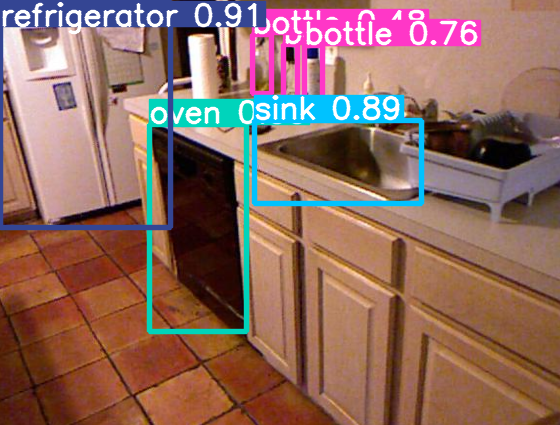

YOLO 🚀 v0.1-104-g5b1ea9a Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)



Question:	 what is on the left side of the container
Answer:		 bottle_of_hand_wash_liquid (Label: 64)
Objects:	 [(3, 'bottle'), (1, 'oven'), (1, 'sink'), (1, 'refrigerator')]
Detected:	 False
Predicted Answer:	 6
Similarity: 0.1828839869281046






Fusing layers... 
Model summary: 839 layers, 68669632 parameters, 0 gradients, 241.4 GFLOPs


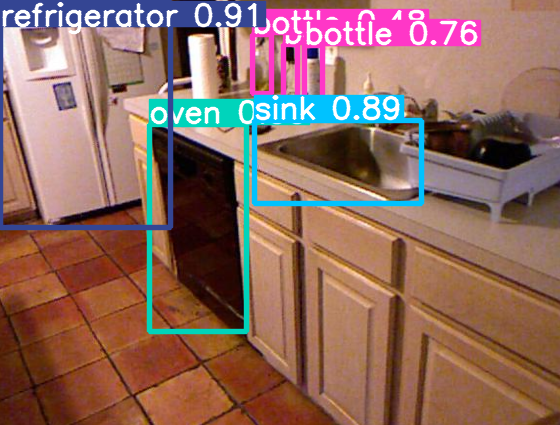

YOLO 🚀 v0.1-104-g5b1ea9a Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)



Question:	 what is on the right side of the tap
Answer:		 kitchen_utensils (Label: 301)
Objects:	 [(3, 'bottle'), (1, 'oven'), (1, 'sink'), (1, 'refrigerator')]
Detected:	 False
Predicted Answer:	 razor
Similarity: 0.588095238095238






Fusing layers... 
Model summary: 839 layers, 68669632 parameters, 0 gradients, 241.4 GFLOPs


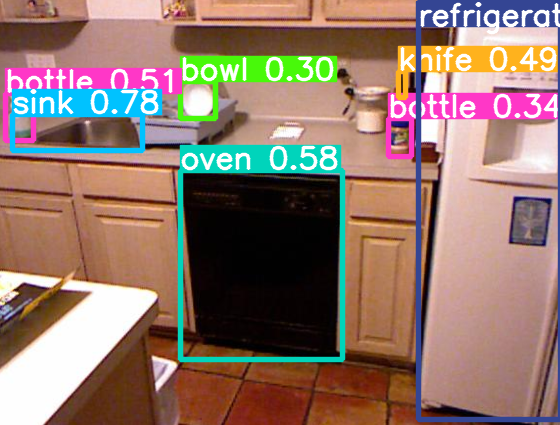

YOLO 🚀 v0.1-104-g5b1ea9a Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)



Question:	 what is on the right side of the cellphone charger
Answer:		 plastic_box (Label: 393)
Objects:	 [(2, 'bottle'), (1, 'knife'), (1, 'bowl'), (1, 'oven'), (1, 'sink'), (1, 'refrigerator')]
Detected:	 False
Predicted Answer:	 door_way_arch
Similarity: 0.24601139601139602






Fusing layers... 
Model summary: 839 layers, 68669632 parameters, 0 gradients, 241.4 GFLOPs


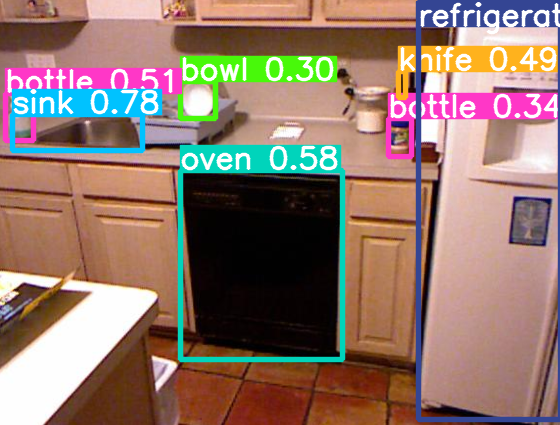

YOLO 🚀 v0.1-104-g5b1ea9a Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (NVIDIA A100-SXM4-40GB, 40514MiB)



Question:	 what is on the right side of the plastic box
Answer:		 knife_rack, knife (Label: 303)
Objects:	 [(2, 'bottle'), (1, 'knife'), (1, 'bowl'), (1, 'oven'), (1, 'sink'), (1, 'refrigerator')]
Detected:	 False
Predicted Answer:	 paper_bundle
Similarity: 0.1815437286025521






Fusing layers... 
Model summary: 839 layers, 68669632 parameters, 0 gradients, 241.4 GFLOPs


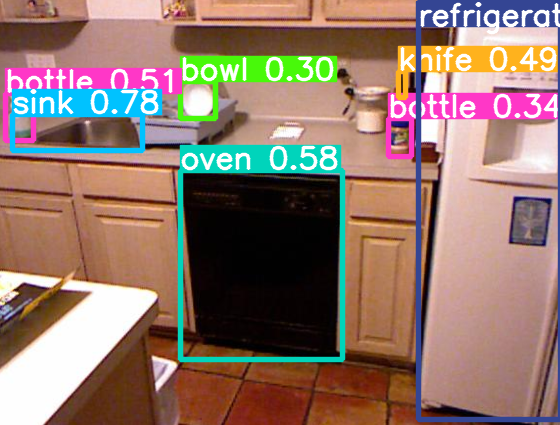

Question:	 what is behind the kitchen utensils
Answer:		 bottle_of_liquid (Label: 65)
Objects:	 [(2, 'bottle'), (1, 'knife'), (1, 'bowl'), (1, 'oven'), (1, 'sink'), (1, 'refrigerator')]
Detected:	 False
Predicted Answer:	 briefcase
Similarity: 0.5222222222222223




In [41]:
from nltk.corpus import wordnet

def similarity(a, b):
    # Split words if it is a list and remove extra spaces
    words_a = [w.strip() for w in a.split(',')]
    words_b = [w.strip() for w in b.split(',')]

    # Split words if connected by underscore _
    a = [w_ for word in words_a for w_ in word.split('_')]
    b = [w_ for word in words_b for w_ in word.split('_')]

    res = 0
    n = 0

    # Calculate score and take average
    for i in a:
        synsets_i = wordnet.synsets(i)
        if synsets_i:
            s1 = synsets_i[0]
            for j in b:
                synsets_j = wordnet.synsets(j)
                if synsets_j:
                    s2 = synsets_j[0]
                    sim = s1.wup_similarity(s2)
                    if sim:
                        res += sim
                    n += 1

    return res / n if n != 0 else 0

# Show predictions for a range of examples
for i in range(2000, 2005):
    print("\n=========================================================\n")
    predicted_answer = answer_space[preds[i - 2000]]
    real_answer = show_example(train=False, idx=i, prediction=predicted_answer)
    print("Predicted Answer:\t", predicted_answer)
    print(f"Similarity: {similarity(real_answer, predicted_answer)}")
    print("\n=========================================================\n")


In [42]:
def count_trainable_parameters(model):
    """
    Count and print the number of trainable parameters in a PyTorch model.

    Args:
        model (torch.nn.Module): The PyTorch model.

    Returns:
        None
    """
    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print("Number of trainable parameters: {:,}".format(num_params))
count_trainable_parameters(model)

Number of trainable parameters: 212,120,390
